# Model implementation

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [113]:
%load_ext autoreload
%autoreload 2

import os
import time
import tqdm
import numpy as np
import pandas as pd

import vis
import softclustering as sc

from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import socceraction.spadl as spadl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

Concatenate actions of all games in one DataFrame.

In [114]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm.tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")

64it [00:00, 209.29it/s]


In [115]:
def consolidate(actions):
    #actions.fillna(0, inplace=True)

    #Consolidate corner_short and corner_crossed
    corner_idx = actions.type_name.str.contains("corner")
    actions["type_name"] = actions["type_name"].mask(corner_idx, "corner")

    #Consolidate freekick_short, freekick_crossed, and shot_freekick
    freekick_idx = actions.type_name.str.contains("freekick")
    actions["type_name"] = actions["type_name"].mask(freekick_idx, "freekick")

    #Consolidate keeper_claim, keeper_punch, keeper_save, keeper_pick_up
    keeper_idx = actions.type_name.str.contains("keeper")
    actions["type_name"] = actions["type_name"].mask(keeper_idx, "keeper_action")

    actions["start_x"] = actions["start_x"].mask(actions.type_name == "shot_penalty", 94.5)
    actions["start_y"] = actions["start_y"].mask(actions.type_name == "shot_penalty", 34)

    return actions


actions = consolidate(actions)

In [116]:
#Actions of Team France matches.
len(actions[actions["team_id"] == 771])

6829

In [117]:
actions.groupby("type_name").size()

type_name
bad_touch         1547
clearance         2074
corner             558
cross             1305
dribble          52731
foul              1876
freekick          1272
goalkick           677
interception      1681
keeper_action      584
pass             56438
shot              1556
shot_penalty        68
tackle            1830
take_on           2109
throw_in          2178
dtype: int64

As suggested in SoccerMix, add noise on the starting and ending locations, but only on those actions that we can visually note a predefined pattern.
* *Add noise in both start and end locations*:
    * Cross
    * Shot
    * Dribble
    * Pass
    * Keeper_action
* *Only on start locations*:
    * Clearance
    * Goal kick
* *Only on end locations*:
    * Throw_in
    * Corner
    * Freekick
    * Shot_penalty

In [118]:
def add_noise(actions):
    # Start locations
    start_list = ["cross", "shot", "dribble", "pass", "keeper_action", "clearance", "goalkick"]
    mask = actions["type_name"].isin(start_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["start_x", "start_y"]].shape)
    actions.loc[mask, ["start_x", "start_y"]] += noise

    # End locations
    end_list = ["cross", "shot", "dribble", "pass", "keeper_action", "throw_in", "corner", "freekick", "shot_penalty"]
    mask = actions["type_name"].isin(end_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["end_x", "end_y"]].shape)
    actions.loc[mask, ["end_x", "end_y"]] += noise

    return actions


actions = add_noise(actions)

In [119]:
# # display event locations with noise
# corrected_actions = ["cross", "shot", "keeper_action", "clearance", "goalkick","corner", "freekick", "shot_penalty"]
# for actiontype in corrected_actions:
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="start_x",
#         y="start_y",
#         title = f"Start Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="end_x",
#         y="end_y",
#         title = f"End Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()

In [120]:
def remove_outliers(actions, verbose=False):
    X = actions[["start_x","start_y","end_x","end_y"]].to_numpy(dtype=float)
    inliers = LocalOutlierFactor(contamination="auto").fit_predict(X)
    if verbose:
        print(f"Remove {(inliers==-1).sum()} out of {X.shape[0]} datapoints.")
    return actions[inliers==1]

actions = remove_outliers(actions,True)

Remove 571 out of 128484 datapoints.


### Features

Compute the angle of the direction of the action with respect with the x-axis (pitch's length) a
$$\tan \theta = \frac{y_{end} - y_{start}}{x_{end} - x_{start}}$$

In [121]:
actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
actions["cos_angle"] = np.cos(actions["angle"])
actions["sin_angle"] = np.sin(actions["angle"])
actions[["angle", "cos_angle", "sin_angle"]].describe()

,angle,cos_angle,sin_angle
count,127913.000000,127913.000000,127913.000000
mean,-0.011584,0.276929,-0.005617
std,1.500941,0.680832,0.678051
min,-3.141429,-1.000000,-1.000000
25%,-1.099060,-0.270678,-0.663749
50%,0.000000,0.472414,0.000000
75%,1.059650,0.925114,0.643643
max,3.141482,1.000000,1.000000


### First run

Let's run a first toy implementation using throw-ins of team France.

In [122]:
mask = (actions["type_name"]=="dribble") & (actions["team_id"]==771)
loc_data = actions[mask][["start_x", "start_y"]]
dir_data = actions[mask][["cos_angle", "sin_angle"]]

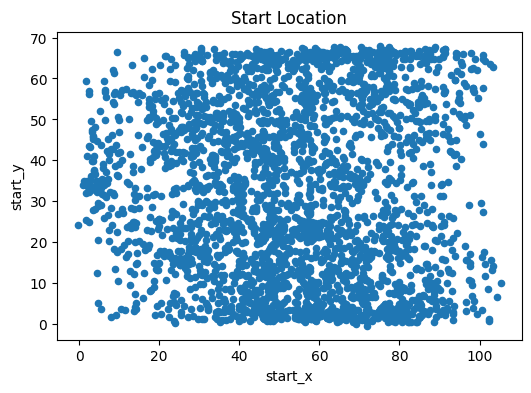

In [123]:
loc_data.plot.scatter(
        x="start_x",
        y="start_y",
        title = f"Start Location",
        figsize = (6,4)
    )
plt.show()

In [124]:
#Gaussian clusters
k_gauss = 7

gauss_clusters = [sc.MultivariateGaussian() for j in range(k_gauss)]

loc_em_model = sc.MixtureModel(gauss_clusters)
loc_bregman_model = sc.MixtureModel(gauss_clusters)

# Classic EM
start = time.time()
res_em = loc_em_model.fit_em_classic(loc_data, verbose=False)
t_em = time.time() - start

# Bregman EM
start = time.time()
res_bregman = loc_bregman_model.fit_em_bregman(loc_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nBregman: {t_bregman:.4f}s")
print(f"Calinski–Harabasz index:\n  EM: {loc_em_model.kl_ch_score(loc_data):.4f}\n"
      f"  Bregman: {loc_bregman_model.kl_ch_score(loc_data):.4f}")

Final log-likelihoods:
EM: -25469.3357
Bregman: -25469.3357
Timings:
EM: 0.4335s
Bregman: 0.3891s
Calinski–Harabasz index:
  EM: 0.8101
  Bregman: 0.8101


In [137]:
for model in [loc_em_model, loc_bregman_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=7)
  ├─ (0) w=0.100  MultivariateGaussian(d=2, mean=[58.101  7.219], cov=[[458.183  18.242], [18.242  9.012]])
  ├─ (1) w=0.022  MultivariateGaussian(d=2, mean=[ 5.126 36.062], cov=[[5.711 0.199], [ 0.199 34.482]])
  ├─ (2) w=0.099  MultivariateGaussian(d=2, mean=[62.18  65.238], cov=[[331.206   4.218], [4.218 1.622]])
  ├─ (3) w=0.299  MultivariateGaussian(d=2, mean=[51.432 20.334], cov=[[477.236  -6.572], [-6.572 57.708]])
  ├─ (4) w=0.092  MultivariateGaussian(d=2, mean=[76.682 55.251], cov=[[163.258 -17.135], [-17.135  37.073]])
  ├─ (5) w=0.106  MultivariateGaussian(d=2, mean=[64.013  2.377], cov=[[270.281   0.288], [0.288 1.176]])
  └─ (6) w=0.281  MultivariateGaussian(d=2, mean=[43.259 46.253], cov=[[335.109 -37.246], [-37.246  86.77 ]])

MixtureModel(n_clusters=7)
  ├─ (0) w=0.100  MultivariateGaussian(d=2, mean=[58.101  7.219], cov=[[458.183  18.242], [18.242  9.012]])
  ├─ (1) w=0.022  MultivariateGaussian(d=2, mean=[ 5.126 36.062], cov=[[5.711 0.199],

In [126]:
#Von Mises Clusters
k_vm = 3

vm_clusters = [sc.VonMises() for _ in range(k_vm)]

dir_em_model = sc.MixtureModel(vm_clusters)
dir_proxy_model = sc.MixtureModel(vm_clusters)
dir_bregman_model = sc.MixtureModel(vm_clusters)

# Classic EM
start = time.time()
res_em = dir_em_model.fit_em_classic(dir_data, verbose=False)
t_em = time.time() - start

# Proxy EM for Von Mises
start = time.time()
res_proxy = dir_proxy_model.fit_em_vonmises_approx(dir_data, verbose=False)
t_proxy = time.time() - start

# Bregman EM
start = time.time()
res_bregman = dir_bregman_model.fit_em_bregman(dir_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nProxy: {res_proxy[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nProxy: {t_proxy:.4f}s\nBregman: {t_bregman:.4f}s")
print(f"Calinski–Harabasz index:\n"
      f"  EM: {dir_em_model.kl_ch_score(loc_data):.4f}\n"
      f"  Bregman: {dir_bregman_model.kl_ch_score(loc_data):.4f}\n"
      f"  Proxy: {dir_proxy_model.kl_ch_score(loc_data):.4f}")


Final log-likelihoods:
EM: -7272.9066
Proxy: -5493.2872
Bregman: -7445.1939
Timings:
EM: 0.5108s
Proxy: 0.0983s
Bregman: 0.1020s
Calinski–Harabasz index:
  EM: -0.0013
  Bregman: -0.0012
  Proxy: -0.0003


In [127]:
for model in [dir_em_model, dir_bregman_model, dir_proxy_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=3)
  ├─ (0) w=0.478  VonMises(loc=8.2º, kappa=1.254)
  ├─ (1) w=0.222  VonMises(loc=-73.0º, kappa=0.878)
  └─ (2) w=0.300  VonMises(loc=134.3º, kappa=0.764)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.518  VonMises(loc=8.2º, kappa=1.254)
  ├─ (1) w=0.237  VonMises(loc=-73.0º, kappa=0.878)
  └─ (2) w=0.245  VonMises(loc=134.3º, kappa=0.764)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.049  VonMises(loc=8.2º, kappa=1.254)
  ├─ (1) w=0.017  VonMises(loc=-73.0º, kappa=0.878)
  └─ (2) w=0.934  VonMises(loc=134.3º, kappa=0.764)



### Two layer scheme

Running a Gaussian mixture model to get location clusters. Then, for each one of the location clusters, run a von Mises mixture model using again all dataset, but for this second step, each datapoint is weighted by the posteriors of the location mixture model.

Running Time bregman Model: 1.2454s



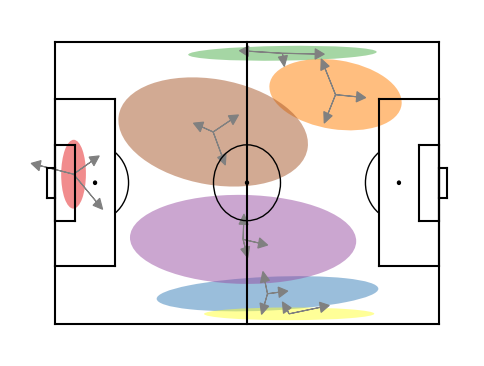

In [128]:
K_loc = 7
K_dir = 3
results = {}

choose = "bregman"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results["bregman"]
vis.show_all_models(gmm, vmm)

In [136]:
vmm[2]

MixtureModel(n_clusters=3)
  ├─ (0) w=0.260  VonMises(loc=-0.9º, kappa=11.358)
  ├─ (1) w=0.641  VonMises(loc=-78.3º, kappa=0.563)
  └─ (2) w=0.099  VonMises(loc=177.1º, kappa=25.246)

Running Time soccermix Model: 1.1262s



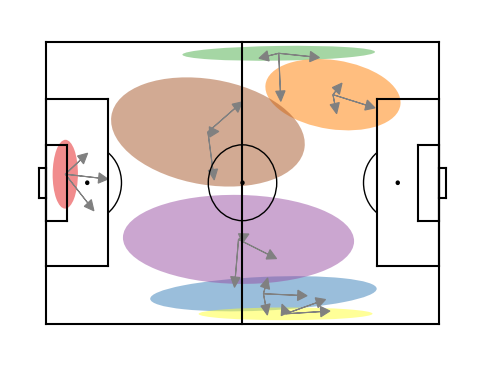

In [130]:
choose = "soccermix"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results[choose]
vis.show_all_models(gmm, vmm)

Running Time classic Model: 4.4604s



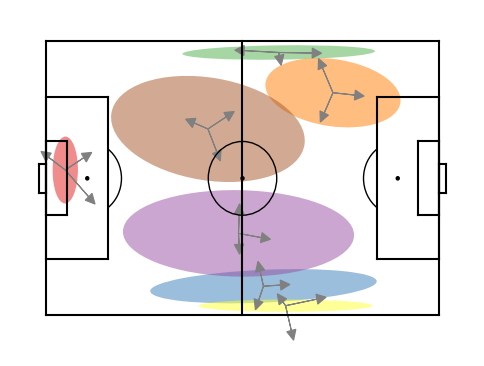

In [131]:
choose = "classic"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results[choose]
vis.show_all_models(gmm, vmm)

In [132]:
rows = []
for key, value in results.items():
    loc_model = value[0]
    dir_models = value[1]

    loc_chi = round(loc_model.kl_ch_score(loc_data),4)
    rows.append({"Model": key, "Component": "loc_model", "CH Index": loc_chi})

    for i, dir_model in enumerate(dir_models):
        dir_chi = round(dir_model.kl_ch_score(dir_data),4)
        rows.append({"Model": key, "Component": f"dir_model_{i}", "CH Index": dir_chi})

# Create DataFrame
scores_df = pd.DataFrame(rows)
scores_df.groupby("Model").sum()

,Component,CH Index
Model,,
bregman,loc_modeldir_model_0dir_model_1dir_model_2dir_...,1.3752
classic,loc_modeldir_model_0dir_model_1dir_model_2dir_...,1.4429
soccermix,loc_modeldir_model_0dir_model_1dir_model_2dir_...,1.3288


In [133]:
# Collect BIC and AIC results
rows = []
for key, value in results.items():
    loc_model = value[0]
    dir_models = value[1]

    loc_bic = round(loc_model.bic_score(loc_data),0)
    loc_aic = round(loc_model.aic_score(loc_data),0)
    rows.append({"Model": key, "Component": "loc_model", "BIC": loc_bic, "AIC": loc_aic})

    for i, dir_model in enumerate(dir_models):
        dir_bic = round(dir_model.bic_score(dir_data),0)
        dir_aic = round(dir_model.aic_score(dir_data),0)
        rows.append({"Model": key, "Component": f"dir_model_{i}", "BIC": dir_bic, "AIC": dir_aic})

# Create DataFrame
scores_df = pd.DataFrame(rows)
scores_df.groupby("Model").sum()


,Component,BIC,AIC
Model,,,
bregman,loc_modeldir_model_0dir_model_1dir_model_2dir_...,123362.0,122911.0
classic,loc_modeldir_model_0dir_model_1dir_model_2dir_...,123175.0,122726.0
soccermix,loc_modeldir_model_0dir_model_1dir_model_2dir_...,123463.0,123012.0
